# Regression with cognitive parameters -CINGULATE region

This corresponds to the visualization on the first HCP half of the t-SNE and clustering of the two models (first model being run on the first half, the second model being run on the second half of HCP)

# 1) Imports

In [617]:
import os
import glob
import sys
import json
import shutil

p = os.path.abspath('../')
if p not in sys.path:
    sys.path.append(p)

In [618]:
import colorado as cld
import dico_toolbox as dtx
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
from scipy.spatial import distance

import plotly.graph_objects as go
import pickle
import matplotlib.pyplot as plt

from soma import aims

import torch

from sklearn.cluster import KMeans, SpectralClustering, AffinityPropagation
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.manifold import TSNE

import matplotlib.cm as cm

from hydra import initialize, initialize_config_module, initialize_config_dir, compose
from omegaconf import OmegaConf, DictConfig

In [619]:
# If true, saves meshes as files
save_mesh = False

# If true, saves buckets as files
save_bucket = False

# 2) Functions and datasets

In [620]:
def closest_distance(centroid, df):
    """Returns closest point to centroid of a given cluster
    /!\ central_point is part of the defined set of points
    Args:
        IN: centroid: tuple of coordinates of centroid
            df: pandas.DataFrame with index corresponding to subjects and as many columns as coordinates
        OUT: central_point: subject ID corresponding to closest point to the centroid
    """
    # df must have as many columns as dimensions to consider
    distances = {}
    # Get distances to centroid for each point
    for sub in list(df.index):
        pos = [df.loc[sub][k] for k in range(0, len(df.columns))]
        distances[sub] = distance.euclidean(pos, centroid)
    # Get closest point to centroid
    central_point = min(distances, key=distances.get)
    return central_point

In [621]:
def mscatter(x, y, ax=None, m=None, **kw):
    if not ax:
        ax = plt.gca()
    sc = ax.scatter(x, y, **kw)
    if (m is not None) and (len(m) == len(x)):
        paths = []
        for marker in m:
            if isinstance(marker, mmarkers.MarkerStyle):
                marker_obj = marker
            else:
                marker_obj = mmarkers.MarkerStyle(marker)
            path = marker_obj.get_path().transformed(
                marker_obj.get_transform())
            paths.append(path)
        sc.set_paths(paths)
    return sc

In [622]:
path = '/host/volatile/jc225751/Runs/35_cingulate_with_distance/Input/Processed_External/crops/2mm/CINGULATE/mask/Rcrops'

In [623]:
run_dir = '/host/volatile/jc225751/Runs/35_cingulate_with_distance'

In [624]:
csv_dir = '/host/volatile/jc225751/Runs/35_cingulate_with_distance/Input'

In [625]:
model_run = 'sigma-1.0'

In [626]:
glob.glob(csv_dir + '/*')

['/host/volatile/jc225751/Runs/35_cingulate_with_distance/Input/HCP_half_1bis.csv',
 '/host/volatile/jc225751/Runs/35_cingulate_with_distance/Input/participants.csv',
 '/host/volatile/jc225751/Runs/35_cingulate_with_distance/Input/HCP_half_2.csv',
 '/host/volatile/jc225751/Runs/35_cingulate_with_distance/Input/Processed_External',
 '/host/volatile/jc225751/Runs/35_cingulate_with_distance/Input/crop_10subjects']

In [627]:
if torch.cuda.is_available():
    device = "cuda:0"
print(device)

cuda:0


## We load hcp_1 result

In [628]:
# We load the embeddings
result_dir = f"{run_dir}/Output/with_forcing/{model_run}"
train_val_embeddings_file = f"{result_dir}/train_val_embeddings.pt"
embeddings = torch.load(train_val_embeddings_file)
print(embeddings.shape)

torch.Size([550, 4])


In [629]:
# We load the labels
with open(f"{result_dir}/train_val_filenames.json", 'r') as f:
    subject_labels = json.load(f)
print(subject_labels[0])    

129634


In [630]:
hcp_1 = pd.DataFrame(embeddings.numpy(), index=subject_labels, columns=[1, 2, 3, 4])
hcp_1.head()

,1,2,3,4
129634,20.245201,7.759629,-3.592638,8.691685
136833,21.223333,12.742026,-4.188405,2.445475
206222,21.873825,9.753388,-4.002507,5.395348
138837,2.051466,23.824657,-5.410322,16.718039
987983,4.487133,19.899191,-4.670960,15.087177


Remove subject '142626'

In [631]:
hcp_1.loc['142626']

1     4.661148
2    18.509636
3    -4.241296
4    16.764362
Name: 142626, dtype: float32

In [632]:
hcp_1 = hcp_1.drop(['142626'])

In [633]:
hcp_1 = hcp_1.dropna()

In [634]:
embeddings = hcp_1.iloc[:,0:4].values

In [635]:
embeddings.shape

(549, 4)

In [636]:
subject_labels = hcp_1.index.values

In [637]:
subject_labels.shape

(549,)

## We load hcp_2 results evaluated on model trained on HCP_1

In [638]:
# We load the embeddings from the second half
result_dir2 = f"{run_dir}/Output/with_forcing_evaluate-seconde-half/{model_run}"
train_val_embeddings_file2 = f"{result_dir2}/train_val_embeddings.pt"
embeddings2 = torch.load(train_val_embeddings_file2)
print(embeddings2.shape)

torch.Size([551, 4])


In [639]:
# We load the labels
with open(f"{result_dir2}/train_val_filenames.json", 'r') as f:
    subject_labels2 = json.load(f)
print(subject_labels2[0])   

765864


In [640]:
hcp_2 = pd.DataFrame(embeddings2.numpy(), index=subject_labels2, columns=[1, 2, 3, 4])
hcp_2.head()

,1,2,3,4
765864,-3.109770,19.857565,-6.060274,0.939459
135124,-0.556103,27.676434,-6.552012,11.252094
171330,17.701462,25.237459,-4.664127,-1.101847
158540,27.766281,6.757732,-4.428090,7.321579
175338,19.032511,6.591712,-3.119659,14.569586


# 3) T-SNE

In [641]:
tsne = TSNE(n_components=2, perplexity=30, init='pca', random_state=50)
X_tsne = tsne.fit_transform(embeddings)

In [642]:
tsne2 = TSNE(n_components=2, perplexity=25, init='pca', random_state=50)
X_tsne2 = tsne2.fit_transform(embeddings2)

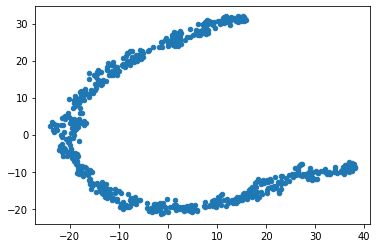

In [643]:
fig, ax = plt.subplots(1)
mscatter(X_tsne[:, 0], X_tsne[:, 1], s=20, ax=ax)
plt.show()


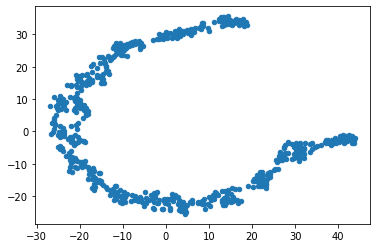

In [644]:
fig, ax = plt.subplots(1)
mscatter(X_tsne2[:, 0], X_tsne2[:, 1], s=20, ax=ax)
plt.show()

In [645]:
X_tsne.shape 

(549, 2)

In [646]:
X_tsne2.shape 

(551, 2)

# Loads HCP csv file and keeps only cognitive parameters

In [647]:
csv_file = f"{csv_dir}/participants.csv"

In [648]:
csv = pd.read_csv(csv_file)

In [649]:
csv.head()

,Subject,Release,Acquisition,Gender,Age,3T_Full_MR_Compl,T1_Count,T2_Count,3T_RS-fMRI_Count,3T_RS-fMRI_PctCompl,...,Noise_Comp,Odor_Unadj,Odor_AgeAdj,PainIntens_RawScore,PainInterf_Tscore,Taste_Unadj,Taste_AgeAdj,Mars_Log_Score,Mars_Errs,Mars_Final
0,100004,S900,Q06,M,22-25,False,0,0,0,0.0,...,5.2,101.12,86.45,2.0,45.9,107.17,105.31,1.80,0.0,1.80
1,100206,S900,Q11,M,26-30,True,1,1,4,100.0,...,6.0,108.79,97.19,1.0,49.7,72.63,72.03,1.84,0.0,1.84
2,100307,Q1,Q01,F,26-30,True,1,1,4,100.0,...,3.6,101.12,86.45,0.0,38.6,71.69,71.76,1.76,0.0,1.76
3,100408,Q3,Q03,M,31-35,True,1,1,4,100.0,...,2.0,108.79,98.04,2.0,52.6,114.01,113.59,1.76,2.0,1.68
4,100610,S900,Q08,M,26-30,True,2,1,4,100.0,...,2.0,122.25,110.45,0.0,38.6,84.84,85.31,1.92,1.0,1.88


In [650]:
csv = csv[['Subject', 'NEOFAC_A', 'NEOFAC_O', 'NEOFAC_C', 'NEOFAC_N', 'NEOFAC_E']]

## Merge it with hcp_1

In [651]:
hcp_1.head()

,1,2,3,4
129634,20.245201,7.759629,-3.592638,8.691685
136833,21.223333,12.742026,-4.188405,2.445475
206222,21.873825,9.753388,-4.002507,5.395348
138837,2.051466,23.824657,-5.410322,16.718039
987983,4.487133,19.899191,-4.670960,15.087177


In [652]:
hcp_1.index

Index(['129634', '136833', '206222', '138837', '987983', '562345', '182032',
       '275645', '151021', '177342',
       ...
       '395958', '154734', '385046', '200008', '792867', '618952', '433839',
       '188448', '166640', '541943'],
      dtype='object', length=549)

In [653]:
csv.Subject = csv.Subject.astype(str).astype(object)

In [654]:
csv.head()

,Subject,NEOFAC_A,NEOFAC_O,NEOFAC_C,NEOFAC_N,NEOFAC_E
0,100004,27.0,15.0,28.0,24.0,25.0
1,100206,29.0,23.0,26.0,21.0,32.0
2,100307,37.0,24.0,35.0,15.0,37.0
3,100408,33.0,29.0,34.0,15.0,33.0
4,100610,31.0,33.0,36.0,7.0,15.0


In [655]:
# Checks which subject of hcp_1 is NOT in participants.csv file
hcp_1.index[~hcp_1.index.isin(csv.Subject)]

Index([], dtype='object')

In [656]:
csv[csv.Subject=='142626']

,Subject,NEOFAC_A,NEOFAC_O,NEOFAC_C,NEOFAC_N,NEOFAC_E


In [657]:
m_1 = pd.merge(hcp_1, csv, left_on=hcp_1.index, right_on=csv.Subject)

In [658]:
m_1.head()

,key_0,1,2,3,4,Subject,NEOFAC_A,NEOFAC_O,NEOFAC_C,NEOFAC_N,NEOFAC_E
0,129634,20.245201,7.759629,-3.592638,8.691685,129634,33.0,26.0,31.0,13.0,34.0
1,136833,21.223333,12.742026,-4.188405,2.445475,136833,36.0,28.0,33.0,23.0,26.0
2,206222,21.873825,9.753388,-4.002507,5.395348,206222,23.0,41.0,31.0,25.0,32.0
3,138837,2.051466,23.824657,-5.410322,16.718039,138837,25.0,30.0,32.0,22.0,28.0
4,987983,4.487133,19.899191,-4.670960,15.087177,987983,32.0,41.0,32.0,13.0,34.0


In [659]:
m_1.shape

(549, 11)

In [660]:
m_1 = m_1.dropna()

In [661]:
m_1 = m_1.set_index('Subject')
m_1 = m_1.drop('key_0', 1)

In [662]:
m_1.head()

,1,2,3,4,NEOFAC_A,NEOFAC_O,NEOFAC_C,NEOFAC_N,NEOFAC_E
Subject,,,,,,,,,
129634,20.245201,7.759629,-3.592638,8.691685,33.0,26.0,31.0,13.0,34.0
136833,21.223333,12.742026,-4.188405,2.445475,36.0,28.0,33.0,23.0,26.0
206222,21.873825,9.753388,-4.002507,5.395348,23.0,41.0,31.0,25.0,32.0
138837,2.051466,23.824657,-5.410322,16.718039,25.0,30.0,32.0,22.0,28.0
987983,4.487133,19.899191,-4.670960,15.087177,32.0,41.0,32.0,13.0,34.0


In [663]:
hcp_1.shape

(549, 4)

In [664]:
m_1.shape

(547, 9)

In [665]:
X = m_1.iloc[:,0:4].values

In [666]:
tsne = TSNE(n_components=2, perplexity=30, init='pca', random_state=50)
X_tsne = tsne.fit_transform(X)

In [667]:
X_tsne.shape

(547, 2)

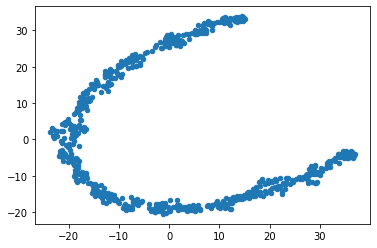

In [668]:
fig, ax = plt.subplots(1)
mscatter(X_tsne[:, 0], X_tsne[:, 1], s=20, ax=ax)
plt.show()


## Merge it with hcp_2

In [669]:
# Checks which subject of hcp_1 is NOT in participants.csv file
hcp_2.index[~hcp_2.index.isin(csv.Subject)]

Index([], dtype='object')

In [670]:
m_2 = pd.merge(hcp_2, csv, left_on=hcp_2.index, right_on=csv.Subject)
m_2.head()

,key_0,1,2,3,4,Subject,NEOFAC_A,NEOFAC_O,NEOFAC_C,NEOFAC_N,NEOFAC_E
0,765864,-3.109770,19.857565,-6.060274,0.939459,765864,35.0,35.0,26.0,27.0,33.0
1,135124,-0.556103,27.676434,-6.552012,11.252094,135124,38.0,31.0,25.0,26.0,37.0
2,171330,17.701462,25.237459,-4.664127,-1.101847,171330,29.0,41.0,29.0,16.0,31.0
3,158540,27.766281,6.757732,-4.428090,7.321579,158540,37.0,18.0,39.0,15.0,35.0
4,175338,19.032511,6.591712,-3.119659,14.569586,175338,29.0,36.0,28.0,24.0,32.0


In [671]:
m_2 = m_2.dropna()

In [672]:
X2 = m_2.iloc[:,0:4].values
X2.shape

(548, 4)

# Regression with cognitive values

In [673]:
from sklearn import linear_model
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import explained_variance_score
from sklearn.metrics import r2_score
import seaborn as sns
from pandas.plotting import scatter_matrix

In [674]:
import statsmodels.api as sm

In [675]:
m_1_5 = m_1[['NEOFAC_A', 'NEOFAC_O', 'NEOFAC_C', 'NEOFAC_N', 'NEOFAC_E']] 
m_1_5.head()

,NEOFAC_A,NEOFAC_O,NEOFAC_C,NEOFAC_N,NEOFAC_E
Subject,,,,,
129634,33.0,26.0,31.0,13.0,34.0
136833,36.0,28.0,33.0,23.0,26.0
206222,23.0,41.0,31.0,25.0,32.0
138837,25.0,30.0,32.0,22.0,28.0
987983,32.0,41.0,32.0,13.0,34.0


In [676]:
m_2_5 = m_2[['NEOFAC_A', 'NEOFAC_O', 'NEOFAC_C', 'NEOFAC_N', 'NEOFAC_E']] 
m_2_5.head()

,NEOFAC_A,NEOFAC_O,NEOFAC_C,NEOFAC_N,NEOFAC_E
0,35.0,35.0,26.0,27.0,33.0
1,38.0,31.0,25.0,26.0,37.0
2,29.0,41.0,29.0,16.0,31.0
3,37.0,18.0,39.0,15.0,35.0
4,29.0,36.0,28.0,24.0,32.0


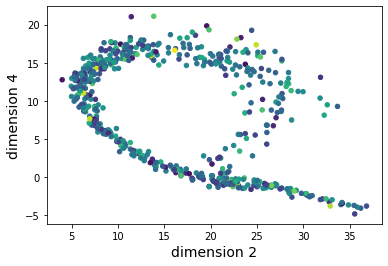

In [677]:
arr = np.array([np.array([m_1[k][i] for k in m_1.columns[[1,3]]]) for i in range(len(m_1))])

fig, ax = plt.subplots()

mscatter(arr[:, 0], arr[:, 1], c=m_1.NEOFAC_N, s=20, ax=ax)

plt.xlabel(f'dimension 2', fontsize=14)
plt.ylabel(f'dimension 4', fontsize=14)
plt.show()

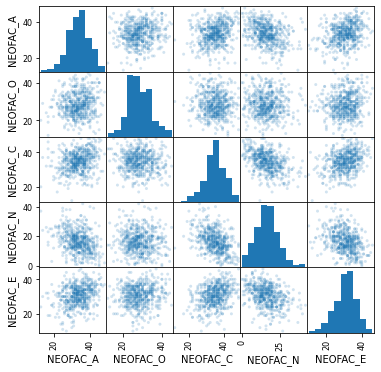

In [678]:
obj = scatter_matrix(m_1_5, alpha=0.2, figsize=(6, 6), diagonal="hist")

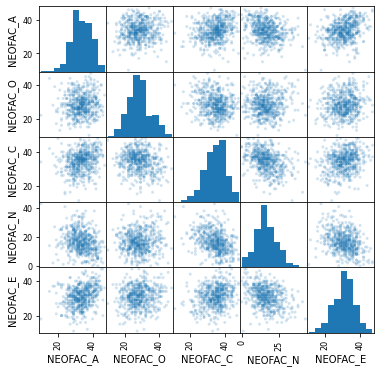

In [679]:
obj2 = scatter_matrix(m_2_5, alpha=0.2, figsize=(6, 6), diagonal="hist")

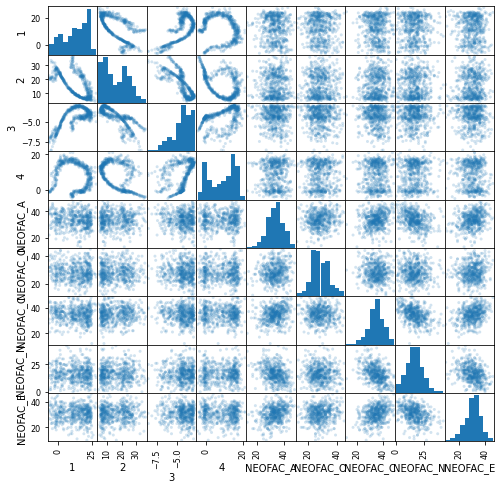

In [680]:
obj3 = scatter_matrix(m_1, alpha=0.2, figsize=(8, 8), diagonal="hist")

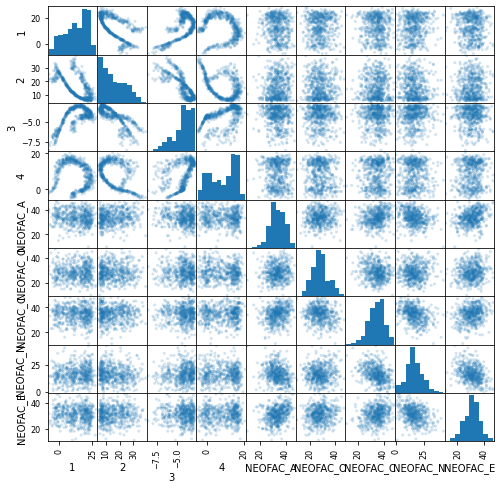

In [681]:
obj3_2 = scatter_matrix(m_2, alpha=0.2, figsize=(8, 8), diagonal="hist")

In [682]:
m_2.head()

,key_0,1,2,3,4,Subject,NEOFAC_A,NEOFAC_O,NEOFAC_C,NEOFAC_N,NEOFAC_E
0,765864,-3.109770,19.857565,-6.060274,0.939459,765864,35.0,35.0,26.0,27.0,33.0
1,135124,-0.556103,27.676434,-6.552012,11.252094,135124,38.0,31.0,25.0,26.0,37.0
2,171330,17.701462,25.237459,-4.664127,-1.101847,171330,29.0,41.0,29.0,16.0,31.0
3,158540,27.766281,6.757732,-4.428090,7.321579,158540,37.0,18.0,39.0,15.0,35.0
4,175338,19.032511,6.591712,-3.119659,14.569586,175338,29.0,36.0,28.0,24.0,32.0


In [683]:
m_2_reduced = m_2[[1,2,3,4,'NEOFAC_C']]

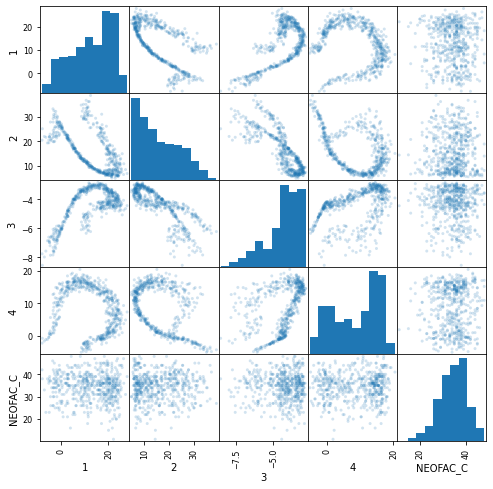

In [684]:
obj3_3 = scatter_matrix(m_2_reduced, alpha=0.2, figsize=(8, 8), diagonal="hist")

In [685]:
m2_3_C = m_2[[3,'NEOFAC_C']]

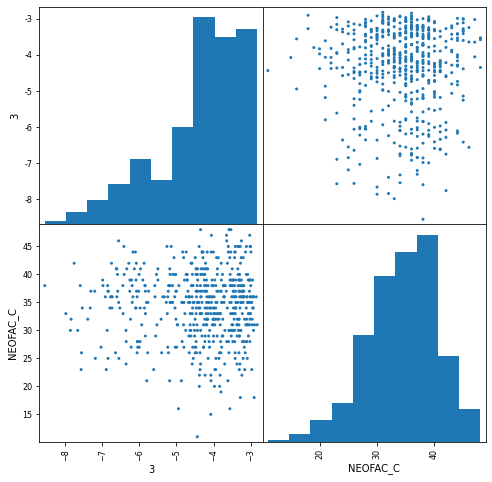

In [686]:
obj3_4 = scatter_matrix(m2_3_C, alpha=1.0, figsize=(8, 8), diagonal="hist")

In [687]:
m_2[3].values.shape

(548,)

In [727]:
m_2_3 = m_2[3].values
m_2_2 = m_2[2].values
m_2_O = m_2['NEOFAC_O'].values
m_2_C = m_2['NEOFAC_C'].values

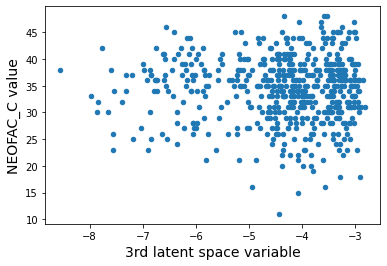

In [689]:
fig, ax = plt.subplots(1)
mscatter(m_2_3, m_2_C, s=20, ax=ax)
plt.xlabel(f'3rd latent space variable', fontsize=14)
plt.ylabel(f'NEOFAC_C value', fontsize=14)
plt.show()

In [710]:
m_2.iloc[:,1:5].values.shape

(548, 4)

In [703]:
from sklearn.feature_selection import mutual_info_classif

In [719]:
m_2_5.head()

,NEOFAC_A,NEOFAC_O,NEOFAC_C,NEOFAC_N,NEOFAC_E
0,35.0,35.0,26.0,27.0,33.0
1,38.0,31.0,25.0,26.0,37.0
2,29.0,41.0,29.0,16.0,31.0
3,37.0,18.0,39.0,15.0,35.0
4,29.0,36.0,28.0,24.0,32.0


In [731]:
m_2.iloc[:,1:5].head()

,1,2,3,4
0,-3.109770,19.857565,-6.060274,0.939459
1,-0.556103,27.676434,-6.552012,11.252094
2,17.701462,25.237459,-4.664127,-1.101847
3,27.766281,6.757732,-4.428090,7.321579
4,19.032511,6.591712,-3.119659,14.569586


In [723]:
for i in range(0,5):
    print(mutual_info_classif(m_2.iloc[:,1:5].values, m_2_5.iloc[:,i]))

[0.         0.         0.031631   0.03014934]
[0.         0.01370384 0.         0.07708783]
[0.         0.         0.01066377 0.04768806]
[0 0 0 0]
[0.01573962 0.02393884 0.04369785 0.        ]


In [728]:
regr_lin = linear_model.LinearRegression()
regr_lin.fit(m_2_2.reshape(-1, 1), m_2_O)
lin_O = regr_lin.predict(m_2_3.reshape(-1, 1))
regr_lin.score(m_2_2.reshape(-1, 1), m_2_O)

9.744441996084596e-05

In [729]:
from sklearn.metrics import explained_variance_score
explained_variance_score(m_2_C, lin_C)

4.860481544688433e-06

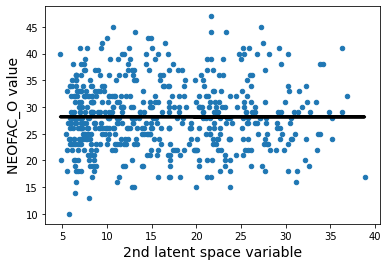

In [730]:
fig, ax = plt.subplots(1)
mscatter(m_2_2, m_2_O, s=20, ax=ax)
plt.plot(m_2_2, lin_O, color="black", linewidth=3)
plt.xlabel(f'2nd latent space variable', fontsize=14)
plt.ylabel(f'NEOFAC_O value', fontsize=14)
plt.show()

In [701]:
m_2_C[m_2_3<-5].mean()

34.82442748091603

In [702]:
m_2_C.mean()

34.34124087591241

In [693]:
y1_5 = m_1_5.values

y1_5 = m_1_5.values

In [694]:
y2_5 = m_2_5.values

In [695]:
X.shape

(547, 4)

In [696]:
np.argwhere(np.isnan(y1_5))

array([], shape=(0, 2), dtype=int64)

In [697]:
m_1.head()

,1,2,3,4,NEOFAC_A,NEOFAC_O,NEOFAC_C,NEOFAC_N,NEOFAC_E
Subject,,,,,,,,,
129634,20.245201,7.759629,-3.592638,8.691685,33.0,26.0,31.0,13.0,34.0
136833,21.223333,12.742026,-4.188405,2.445475,36.0,28.0,33.0,23.0,26.0
206222,21.873825,9.753388,-4.002507,5.395348,23.0,41.0,31.0,25.0,32.0
138837,2.051466,23.824657,-5.410322,16.718039,25.0,30.0,32.0,22.0,28.0
987983,4.487133,19.899191,-4.670960,15.087177,32.0,41.0,32.0,13.0,34.0


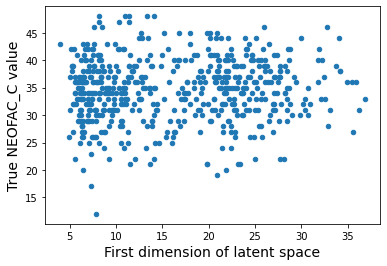

In [698]:
fig, ax = plt.subplots(1)
mscatter(m_1.iloc[:,1], m_1.NEOFAC_C, s=20, ax=ax)
plt.xlabel(f'First dimension of latent space', fontsize=14)
plt.ylabel(f'True NEOFAC_C value', fontsize=14)
plt.show()

# Gets prediction and score

We may want ot compute it each time during learning. We can take this as a score for the grid search